<a href="https://colab.research.google.com/github/Omar-Ouardighi/Lithology-Prediction-Force-2020-Competition/blob/main/Lithology_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

In [2]:
train_df = pd.read_csv('drive/MyDrive/Train.csv',sep=';')
test_df = pd.read_csv('drive/MyDrive/test.csv',sep=';')
print(train_df.shape, test_df.shape)
train_df.head()

(1170511, 29) (136786, 27)


,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-13,494.528,437641.96875,6470972.5,-469.501831,NORDLAND GP.,NaN,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,NaN,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,65000,1.0
1,15/9-13,494.680,437641.96875,6470972.5,-469.653809,NORDLAND GP.,NaN,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,NaN,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,65000,1.0
2,15/9-13,494.832,437641.96875,6470972.5,-469.805786,NORDLAND GP.,NaN,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,NaN,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,65000,1.0
3,15/9-13,494.984,437641.96875,6470972.5,-469.957794,NORDLAND GP.,NaN,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,NaN,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,65000,1.0
4,15/9-13,495.136,437641.96875,6470972.5,-470.109772,NORDLAND GP.,NaN,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,NaN,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,65000,1.0


#  Exploration Data Analysis

In [3]:
miss_features = []
for i in train_df.columns:
  if i not in test_df.columns:
    miss_features.append(i)
print(f'The columns that are not in test data: \n {miss_features}')

The columns that are not in test data: 
 ['FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE']


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170511 entries, 0 to 1170510
Data columns (total 29 columns):
 #   Column                             Non-Null Count    Dtype  
---  ------                             --------------    -----  
 0   WELL                               1170511 non-null  object 
 1   DEPTH_MD                           1170511 non-null  float64
 2   X_LOC                              1159736 non-null  float64
 3   Y_LOC                              1159736 non-null  float64
 4   Z_LOC                              1159736 non-null  float64
 5   GROUP                              1169233 non-null  object 
 6   FORMATION                          1033517 non-null  object 
 7   CALI                               1082634 non-null  float64
 8   RSHA                               630650 non-null   float64
 9   RMED                               1131518 non-null  float64
 10  RDEP                               1159496 non-null  float64
 11  RHOB                    

##Well Data Distribution:
In the figure below, geographical well locations are plotted using X and Y coordinates  It is clear that we are dealing with almost three clusters of wells, NW, SW, and NE. We can see that test wells are chosen fairly consistent with whole data points distribution. *italicized text*

Text(0, 0.5, 'Y_coordinate (UTM)')

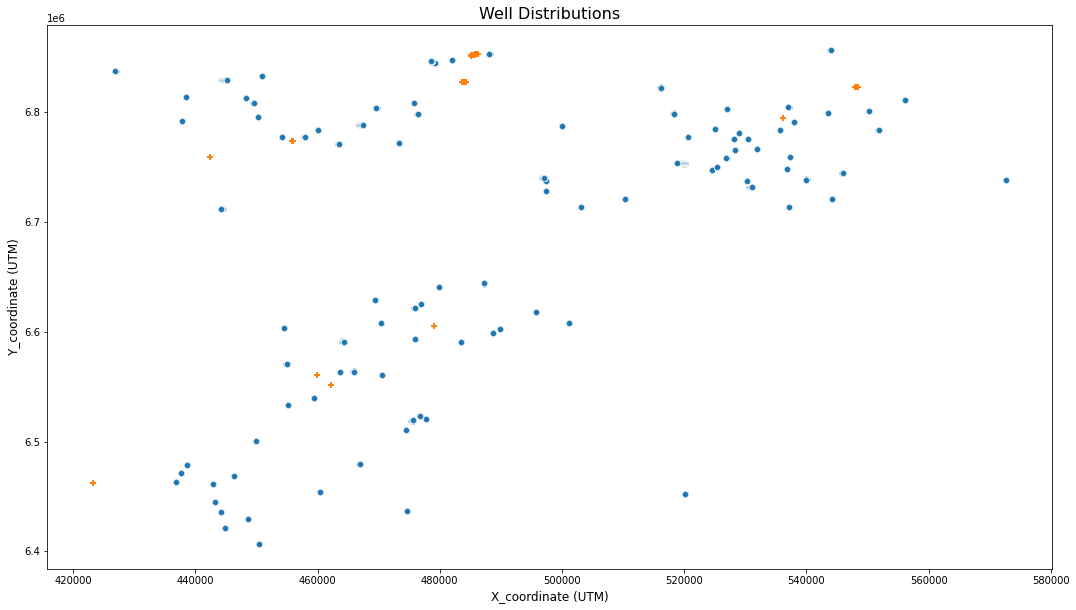

In [5]:
fig, ax = plt.subplots(figsize=(18,10))

sns.scatterplot(data=train_df, x='X_LOC', y='Y_LOC', 
               ax=ax)
sns.scatterplot(data=test_df, x='X_LOC', y='Y_LOC', 
               ax=ax, marker='+')

ax.set_title('Well Distributions', fontsize = '16')
ax.set_xlabel('X_coordinate (UTM)', fontsize = '12')
ax.set_ylabel('Y_coordinate (UTM)', fontsize = '12')

In [6]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

In [7]:
train_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].unique()

array([65000, 30000, 65030, 70000, 99000, 80000, 86000, 74000, 70032,
       90000, 88000, 93000])

Lithologies are not equally likely. This is reflected in this dataset.

Text(0, 0.5, 'Lithology presence (\\%)')

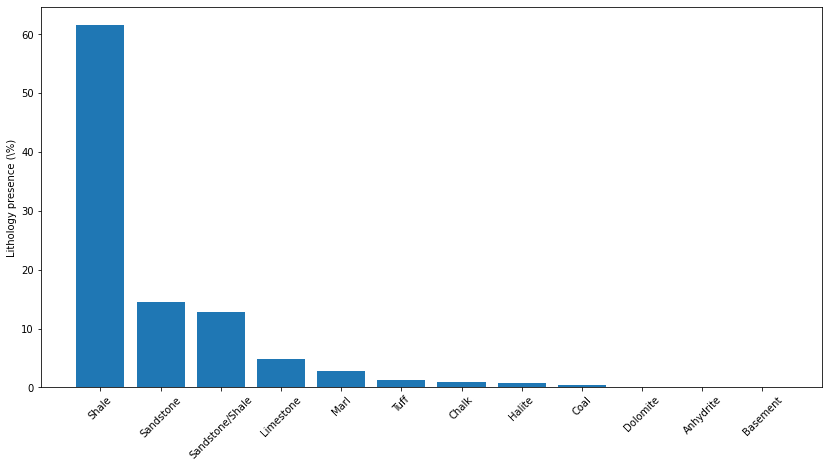

In [8]:
counts = train_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].value_counts()
names = []
percentage = []
N = train_df['FORCE_2020_LITHOFACIES_LITHOLOGY'].shape[0]
for item in counts.items():
    names.append(lithology_keys[item[0]])
    percentage.append(float(item[1])/N*100)
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(len(names)), height=percentage)
ax.set_xticklabels(names, rotation=45)
ax.set_xticks(np.arange(len(names)))
ax.set_ylabel('Lithology presence (\%)')

## Missing Logs
The only log columns that are **guaranteed** to be present are WELL, DEPT, and GR. All other logs can (and will) be missing from some parts of the dataset.

In [9]:
train_df.isna().sum()

WELL                                       0
DEPTH_MD                                   0
X_LOC                                  10775
Y_LOC                                  10775
Z_LOC                                  10775
GROUP                                   1278
FORMATION                             136994
CALI                                   87877
RSHA                                  539861
RMED                                   38993
RDEP                                   11015
RHOB                                  161269
GR                                         0
SGR                                  1101158
NPHI                                  405102
PEF                                   498819
DTC                                    80863
SP                                    306264
BS                                    487854
ROP                                   635440
DTS                                   995898
DCAL                                  871678
DRHO      

Text(0, 0.5, 'Well presence (\\%)')

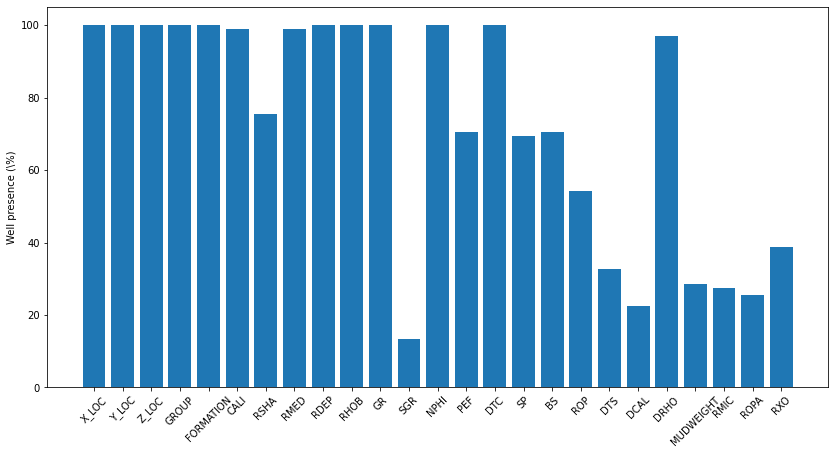

In [10]:
occurences = np.zeros(25)
for well in train_df['WELL'].unique():
    occurences += train_df[train_df['WELL'] == well].isna().all().astype(int).values[2:-2]
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.bar(x=np.arange(occurences.shape[0]), height=(train_df.WELL.unique().shape[0]-occurences)/train_df.WELL.unique().shape[0]*100.0)
ax.set_xticklabels(train_df.columns[2:-2], rotation=45)
ax.set_xticks(np.arange(occurences.shape[0]))
ax.set_ylabel('Well presence (\%)')

#Preprocessing

We should convert lithology labels to numbers 0-11 before training

In [14]:
y= train_df['FORCE_2020_LITHOFACIES_LITHOLOGY']

lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

y = y.map(lithology_numbers)
y.value_counts()

2     720803
0     168937
1     150455
5      56320
3      33329
9      15245
6      10513
7       8213
10      3820
4       1688
8       1085
11       103
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, dtype: int64

## Data Encoding

In [15]:
train_df['GROUP_encoded'] = train_df['GROUP'].astype('category')
train_df['GROUP_encoded'] = train_df['GROUP_encoded'].cat.codes

train_df['FORMATION_encoded'] = train_df['FORMATION'].astype('category')
train_df['FORMATION_encoded'] = train_df['FORMATION_encoded'].cat.codes

train_df['WELL_encoded'] = train_df['WELL'].astype('category')
train_df['WELL_encoded'] = train_df['WELL_encoded'].cat.codes

train_df.shape

(1170511, 32)

In [17]:
X = train_df.drop(columns=['WELL','GROUP', 'FORMATION', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE'])

In [19]:
X.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,GROUP_encoded,FORMATION_encoded,WELL_encoded
0,494.528,437641.96875,6470972.5,-469.501831,19.480835,NaN,1.611410,1.798681,1.884186,80.200851,NaN,NaN,20.915468,161.131180,24.612379,NaN,34.636410,NaN,NaN,-0.574928,NaN,NaN,NaN,NaN,6,-1,0
1,494.680,437641.96875,6470972.5,-469.653809,19.468800,NaN,1.618070,1.795641,1.889794,79.262886,NaN,NaN,19.383013,160.603470,23.895531,NaN,34.636410,NaN,NaN,-0.570188,NaN,NaN,NaN,NaN,6,-1,0
2,494.832,437641.96875,6470972.5,-469.805786,19.468800,NaN,1.626459,1.800733,1.896523,74.821999,NaN,NaN,22.591518,160.173615,23.916357,NaN,34.779556,NaN,NaN,-0.574245,NaN,NaN,NaN,NaN,6,-1,0
3,494.984,437641.96875,6470972.5,-469.957794,19.459282,NaN,1.621594,1.801517,1.891913,72.878922,NaN,NaN,32.191910,160.149429,23.793688,NaN,39.965164,NaN,NaN,-0.586315,NaN,NaN,NaN,NaN,6,-1,0
4,495.136,437641.96875,6470972.5,-470.109772,19.453100,NaN,1.602679,1.795299,1.880034,71.729141,NaN,NaN,38.495632,160.128342,24.104078,NaN,57.483765,NaN,NaN,-0.597914,NaN,NaN,NaN,NaN,6,-1,0


## Filling Missing Data

I decided to replace the missing data with a distnict value different from the other values

In [21]:
X.fillna(-9999, inplace=True)
X.isna().sum()

DEPTH_MD             0
X_LOC                0
Y_LOC                0
Z_LOC                0
CALI                 0
RSHA                 0
RMED                 0
RDEP                 0
RHOB                 0
GR                   0
SGR                  0
NPHI                 0
PEF                  0
DTC                  0
SP                   0
BS                   0
ROP                  0
DTS                  0
DCAL                 0
DRHO                 0
MUDWEIGHT            0
RMIC                 0
ROPA                 0
RXO                  0
GROUP_encoded        0
FORMATION_encoded    0
WELL_encoded         0
dtype: int64


#Modeling


In [22]:
A = np.load('drive/MyDrive/penalty_matrix.npy')
A

array([[0.   , 2.   , 3.5  , 3.   , 3.75 , 3.5  , 3.5  , 4.   , 4.   ,
        2.5  , 3.875, 3.25 ],
       [2.   , 0.   , 2.375, 2.75 , 4.   , 3.75 , 3.75 , 3.875, 4.   ,
        3.   , 3.75 , 3.   ],
       [3.5  , 2.375, 0.   , 2.   , 3.5  , 3.5  , 3.75 , 4.   , 4.   ,
        2.75 , 3.25 , 3.   ],
       [3.   , 2.75 , 2.   , 0.   , 2.5  , 2.   , 2.25 , 4.   , 4.   ,
        3.375, 3.75 , 3.25 ],
       [3.75 , 4.   , 3.5  , 2.5  , 0.   , 2.625, 2.875, 3.75 , 3.25 ,
        3.   , 4.   , 3.625],
       [3.5  , 3.75 , 3.5  , 2.   , 2.625, 0.   , 1.375, 4.   , 3.75 ,
        3.5  , 4.   , 3.625],
       [3.5  , 3.75 , 3.75 , 2.25 , 2.875, 1.375, 0.   , 4.   , 3.75 ,
        3.125, 4.   , 3.75 ],
       [4.   , 3.875, 4.   , 4.   , 3.75 , 4.   , 4.   , 0.   , 2.75 ,
        3.75 , 3.75 , 4.   ],
       [4.   , 4.   , 4.   , 4.   , 3.25 , 3.75 , 3.75 , 2.75 , 0.   ,
        4.   , 4.   , 3.875],
       [2.5  , 3.   , 2.75 , 3.375, 3.   , 3.5  , 3.125, 3.75 , 4.   ,
        0.   , 2.5  

In [26]:
def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

In [28]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
model = XGBClassifier(random_state=42)
for (train_index, test_index) in kf.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))

[0]	validation_0-merror:0.278929
Will train until validation_0-merror hasn't improved in 100 rounds.
[99]	validation_0-merror:0.173859
Default score: -0.46346533363519477
Accuracy is: 0.8261406304062742
F1 is: 0.8402979656675632
None
[0]	validation_0-merror:0.284145
Will train until validation_0-merror hasn't improved in 100 rounds.
[99]	validation_0-merror:0.174945
Default score: -0.4661846118358664
Accuracy is: 0.8250548906032413
F1 is: 0.839768931379816
None
[0]	validation_0-merror:0.285833
Will train until validation_0-merror hasn't improved in 100 rounds.
[99]	validation_0-merror:0.174219
Default score: -0.46351163168191645
Accuracy is: 0.8257810697900915
F1 is: 0.8402528347989057
None
[0]	validation_0-merror:0.283624
Will train until validation_0-merror hasn't improved in 100 rounds.
[99]	validation_0-merror:0.174031
Default score: -0.46525125799865014
Accuracy is: 0.8259690220502174
F1 is: 0.8399749986304798
None
[0]	validation_0-merror:0.284508
Will train until validation_0-mer

In [29]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

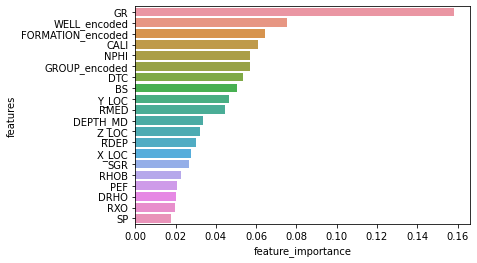

In [30]:
plot_features(X.columns, model.feature_importances_)